In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import scipy

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-10-30 11:37:47.278420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 11:37:47.389986: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 11:37:47.394757: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-30 11:37:47.394773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
# raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.normalized.txt"


""" Load the raw expression """
df = pd.read_csv(raw_path, index_col=0)

# remove MT genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]


print(f"{df.shape=}")
df = df.drop(mt_genes)
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

df.shape=(19393, 18)
df.shape=(19380, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19380


Text(0.5, 0, 'Time (hr)')

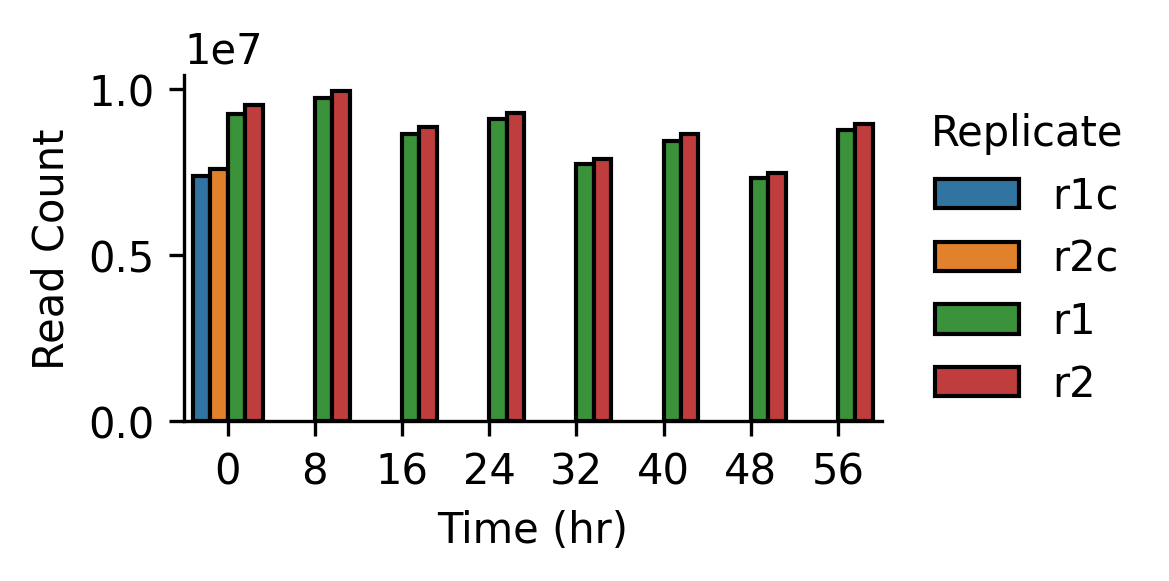

In [3]:
read_sums = df.sum(axis=0)

rdf = pd.DataFrame(read_sums).reset_index(drop=False)
rdf.columns = ['id', 'read_count']
rdf['timepoint'] = rdf['id'].map(nb.tmap)
rdf['time'] = rdf['timepoint'] * 8
rdf['replicate'] = rdf['id'].map(nb.rmap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 1.5

sns.barplot(data=rdf, 
            x='time',
            y='read_count',
            hue='replicate',
            ec='k',
           )

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4, 1),
                title="Replicate")

plt.ylabel("Read Count")
plt.xlabel("Time (hr)")

In [4]:
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"
gf = nb.getGeneLengths(raw_path, gene_names)
gf.head()

/tmp/ipykernel_2823680/321717080.py:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(raw_path, gene_names)


,gene_name,Length
0,A1BG,8315
1,A1CF,86267
2,A2M,48566
3,A2ML1,64381
4,A3GALT2,14333


tpm.shape=(19380, 18) cpm.shape=(19380, 18)


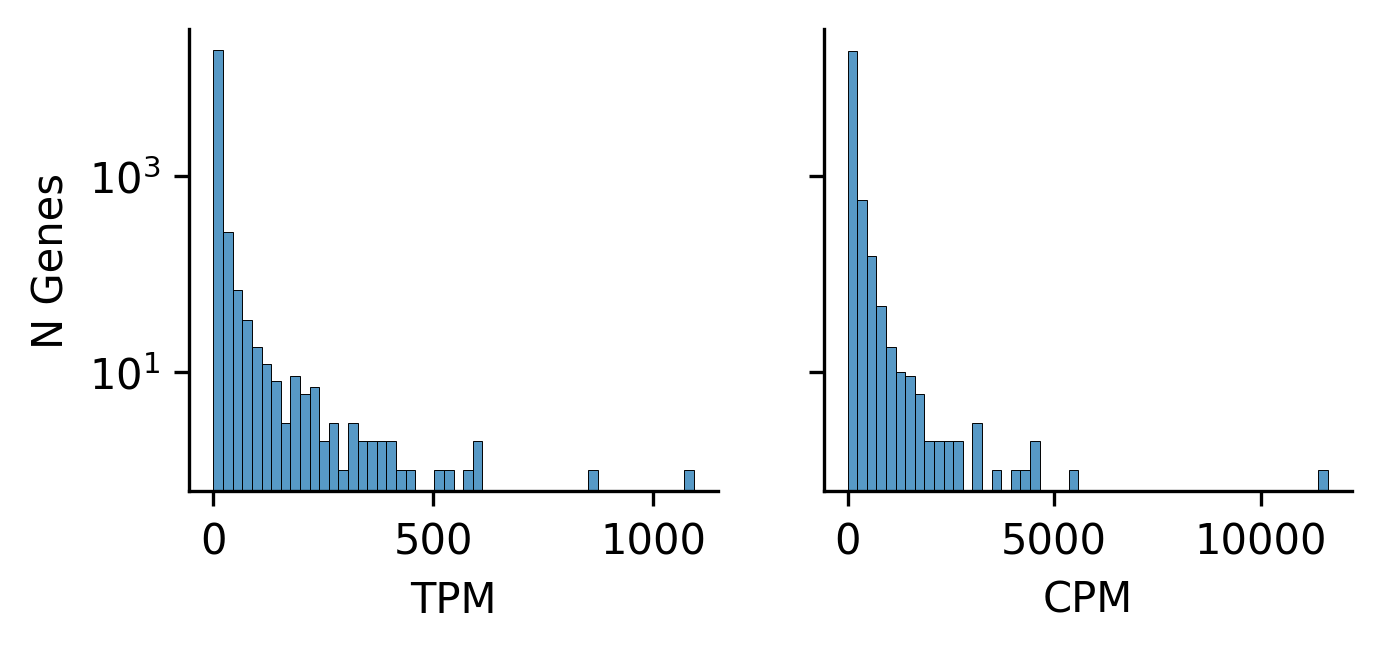

In [5]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)
cpm = nb.CPM(df, target=target)
print(f"{tpm.shape=} {cpm.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

bins = 50
fig, axs = plt.subplots(1, 2, sharey=True)

tpm_dist = tpm.mean(axis=1)
cpm_dist = cpm.mean(axis=1)

sns.histplot(tpm_dist,
             bins=bins,
             ax=axs[0])

axs[0].set_yscale('log')
axs[0].set_xlabel("TPM")
axs[0].set_ylabel("N Genes")

sns.histplot(cpm_dist,
             bins=bins,
             ax=axs[1])

axs[1].set_yscale('log')
axs[1].set_xlabel("CPM")
sns.despine()

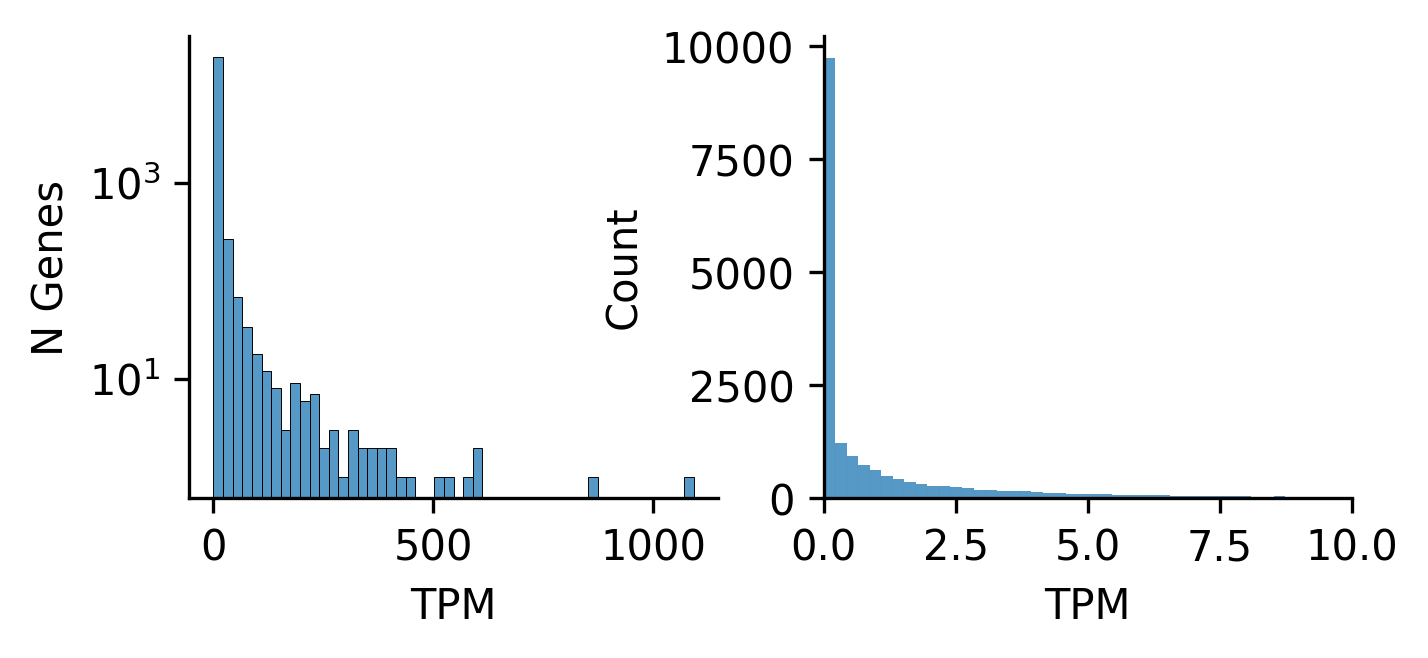

In [24]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

bins = 50
fig, axs = plt.subplots(1, 2)

tpm_dist = tpm.mean(axis=1)

sns.histplot(tpm_dist,
             bins=50,
             ax=axs[0])

axs[0].set_yscale('log')
axs[0].set_xlabel("TPM")
axs[0].set_ylabel("N Genes")

sns.histplot(tpm_dist,
             bins=5000,
             ax=axs[1])

axs[1].set_xlim([0, 10])

axs[1].set_xlabel("TPM")
sns.despine()

In [6]:
# who are the most highly expressed genes?
tpm_means = tpm.mean(axis=1)
tpm[tpm_means > 500]

,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
B2M,578.673418,568.966051,521.216117,511.171174,619.937772,614.068290,702.118116,696.377385,581.557453,573.298164,615.604838,607.211188,661.689999,651.967320,600.749993,597.489010,638.528716,632.662022
FTL,569.072670,578.442324,597.914999,592.745061,614.021777,606.666311,493.736230,506.396953,513.889709,519.151095,528.345128,537.852550,551.747171,554.864965,529.620952,528.409702,486.675900,496.271222
GAPDH,957.301493,958.610628,1013.313147,1015.794885,1021.631071,1029.519384,937.627074,960.853125,1098.922052,1117.428666,1176.608235,1182.074762,1154.857443,1162.919440,1231.198691,1273.282484,1180.941874,1184.303123
HLA-DRA,626.507339,621.477685,495.605370,499.496790,573.691390,567.050834,650.795489,651.534454,555.617620,559.632270,605.357187,604.098748,677.764491,688.488471,574.404227,572.634581,598.539092,595.061753
RPL8,552.829851,559.647274,540.596833,541.260714,431.054987,428.474758,505.860701,508.783661,478.046928,496.805366,508.362513,519.215401,506.816708,510.848510,511.349496,514.132093,502.125679,517.324703
RPS6,602.192059,606.338334,537.889820,537.831575,531.504544,536.822454,601.606481,599.419224,559.867710,554.590484,575.933859,576.099840,622.593642,622.000645,569.162500,563.841230,558.749624,558.301696
TMSB4X,974.848256,1000.417850,943.922402,956.609186,748.331562,745.311973,1019.156275,1019.203239,840.050003,847.192896,856.197225,847.147735,849.322611,844.600254,774.726051,788.485484,839.177486,828.257997


In [7]:
# threshold = 100
threshold = 5
target = 1e6
norm = nb.TPM(df, gf, target=target)
# norm = nb.CPM(df, target=target)

gene_dist = norm.mean(axis=1)
mask = (gene_dist > threshold)
print(f"N genes with mean normed expression > {threshold} = {mask.sum()}")

high_exp_genes = gene_dist[mask].index 

ddf = norm[norm.index.isin(high_exp_genes)]
print(f"{ddf.shape=}")

N genes with mean normed expression > 5 = 2167
ddf.shape=(2167, 18)


Text(0.5, 0, 'Time (hr)')

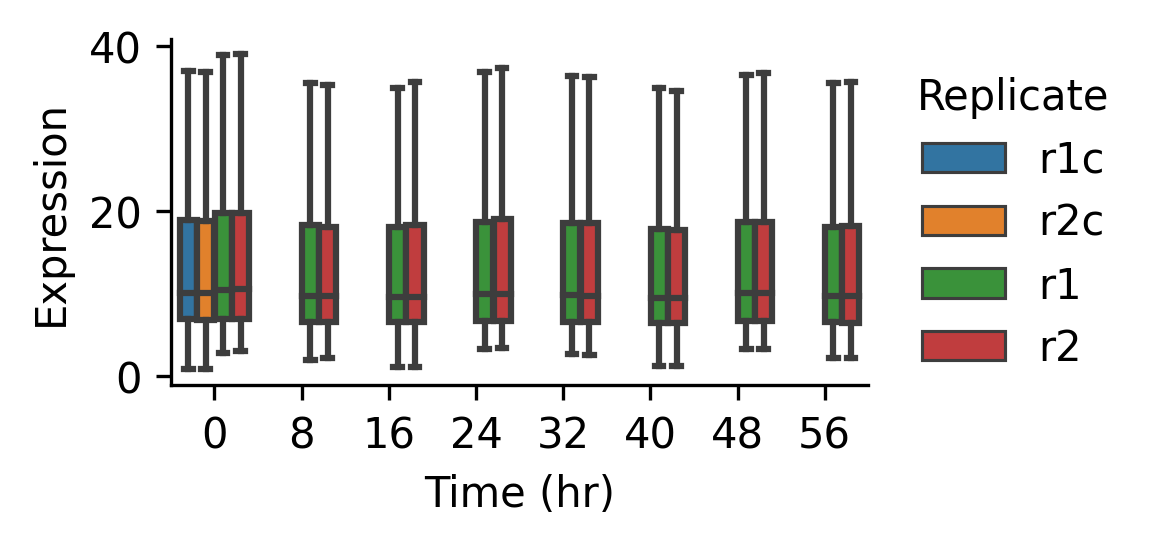

In [8]:
pdf = ddf.copy()
pdf = pdf.reset_index(drop=False)

pdf = pd.melt(pdf, id_vars='geneName')

pdf['timepoint'] = pdf['variable'].map(nb.tmap)
pdf['replicate'] = pdf['variable'].map(nb.rmap)
pdf['hours'] = pdf['timepoint'] * 8

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 1.5

sns.boxplot(data=pdf, 
            x='hours',
            y='value',
            hue='replicate',
            showfliers=False)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4, 1),
                title="Replicate")

plt.ylabel("Expression")
plt.xlabel("Time (hr)")

# Changing TPM/CPM thresholds

,Threshold,variable,value
0,0,Genes (TPM),16361
1,2,Genes (TPM),4514
2,4,Genes (TPM),2679
3,6,Genes (TPM),1803
4,8,Genes (TPM),1343


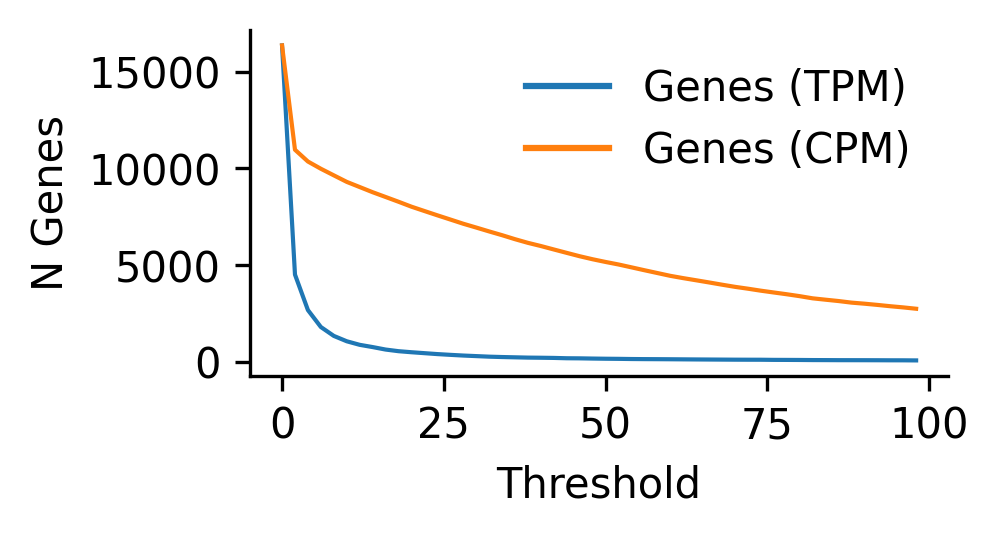

In [9]:

target = 1e6
tmp = nb.TPM(df, gf, target=target)
cpm = nb.CPM(df, target=target)

tpm_dist = tmp.mean(axis=1)
cpm_dist = cpm.mean(axis=1)

res = []

for t in np.arange(0, 100, 2):
    tpm_kept = (tpm_dist > t).sum()
    cpm_kept = (cpm_dist > t).sum()

    row = {
        'Threshold' : t,
        'Genes (TPM)' : tpm_kept,
        'Genes (CPM)' : cpm_kept,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = pd.melt(res, id_vars='Threshold')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 1.5

sns.lineplot(data=res, 
             x='Threshold',
             y='value',
             hue='variable',
             lw=1,)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="")

plt.ylabel("N Genes")
plt.xlabel("Threshold")

res.head()

# effect of TPM filtering on all genes

len(cc_genes)=97


,threshold,n_genes,perc
0,0.00,16361,0.844221
1,0.25,9436,0.486894
2,0.50,8137,0.419866
3,0.75,7159,0.369401
4,1.00,6368,0.328586


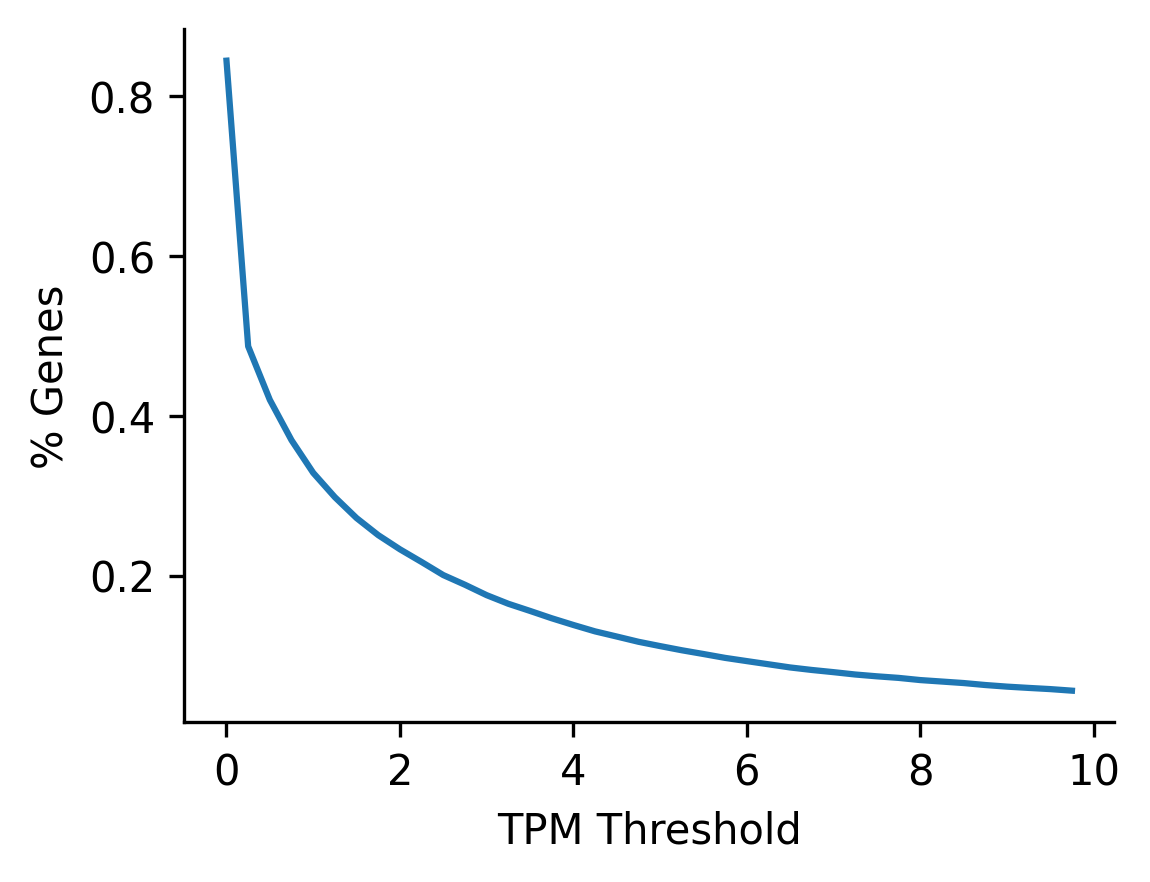

In [30]:
cc_genes = list(set(nb.s_genes + nb.g2_genes))
print(f"{len(cc_genes)=}")

target = 1e6
tpm = nb.TPM(df, gf, target=target)

n_genes = len(tpm_dist)

tpm_dist = tpm.mean(axis=1)

res = []

for i, t in enumerate(np.arange(0, 10, 0.25)):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    

    # print(f"TPM threshold: {t} {len(high_exp_genes)=}")

    n_hits = np.sum([1 for x in cc_genes if x in high_exp_genes])
    row = {
        'threshold' : t,
        'n_genes' : len(high_exp_genes),
        'perc' : len(high_exp_genes) / n_genes
    }
    res.append(row)

    # break
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res, 
             x='threshold',
             y='perc')

plt.ylabel("% Genes")
plt.xlabel("TPM Threshold")

sns.despine()

res.head()

# TPM threshold and cell cycle regulators

len(cc_genes)=97


,threshold,n_hits,perc_cc_genes,n_genes
0,0.00,97,1.000000,16361
1,0.25,96,0.989691,9436
2,0.50,90,0.927835,8137
3,0.75,89,0.917526,7159
4,1.00,84,0.865979,6368


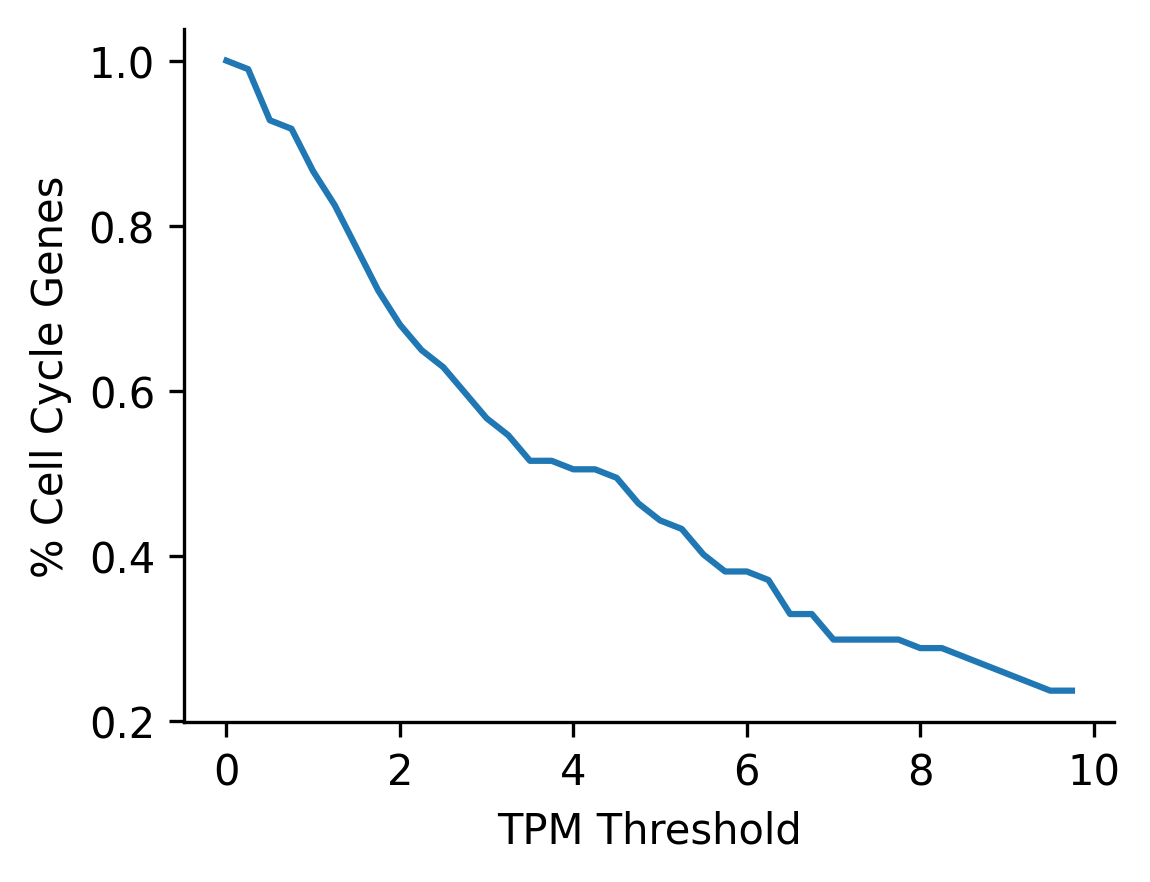

In [31]:
cc_genes = list(set(nb.s_genes + nb.g2_genes))
print(f"{len(cc_genes)=}")

target = 1e6
tpm = nb.TPM(df, gf, target=target)

tpm_dist = tpm.mean(axis=1)

res = []

for i, t in enumerate(np.arange(0, 10, 0.25)):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    

    # print(f"TPM threshold: {t} {len(high_exp_genes)=}")

    n_hits = np.sum([1 for x in cc_genes if x in high_exp_genes])
    row = {
        'threshold' : t,
        'n_hits' : n_hits,
        'perc_cc_genes' : n_hits / len(cc_genes),
        'n_genes' : len(high_exp_genes),
    }
    res.append(row)

    # break
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res, 
             x='threshold',
             y='perc_cc_genes')

plt.ylabel("% Cell Cycle Genes")
plt.xlabel("TPM Threshold")

sns.despine()

res.head()

In [11]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# build fold-change dataframe
dmd_data = nb.data2DMD(ddf)
print(f"{dmd_data.shape=}")

mu_data = nb.getMuData(ddf)
mu_data.shape

mu_data.head()

# plot some random gene trajectories

In [ ]:
n = 12
target = 1e6
threshold = 10
tpm = nb.TPM(df, gf, target=target)

# filter genes
gene_dist = tpm.mean(axis=1)
mask = (gene_dist > threshold)
print(f"N genes with mean normed expression > {threshold} = {mask.sum()}")

high_exp_genes = gene_dist[mask].index 
tpm = tpm[tpm.index.isin(high_exp_genes)]
print(f"{tpm.shape=}")


tpm = tpm.reset_index(drop=False)

pdf = nb.meltDf(tpm)

r_genes = np.random.choice(pdf['geneName'].unique(), n, replace=False)
pdf = pdf[pdf['geneName'].isin(r_genes)]
pdf = pdf[pdf['control'] != 'control']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 5

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
axs = axs.ravel()

for i, (gene, group) in enumerate(pdf.groupby('geneName')):

    # print(group)

    sns.lineplot(data=group,
                 x='hours',
                 y='value',
                 hue='replicate',
                 legend=False,
                 ax=axs[i])

    axs[i].set_title(gene)
    axs[i].set_ylabel("TPM")
    axs[i].set_xlabel("Time (hrs)")
    axs[i].set_yscale("log")
    # break

plt.tight_layout()

In [ ]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)

tpm_dist = tpm.mean(axis=1)

res = []

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 18, 9

fig, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, t in enumerate(np.arange(0, 20, 2)):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    
    d = tpm[tpm.index.isin(high_exp_genes)]

    dmd_data = nb.data2DMD(d) # coverts to FC

    r1 = np.corrcoef(dmd_data[:, :, 0].T)

    sns.heatmap(r1, 
                ax=axs[i],
                cbar=False,
                annot=True, 
                fmt=".2f",
                annot_kws={'fontsize' : 8},
                # vmax=1, 
                # vmin=-1,
                cmap='RdYlGn',
                lw=0.4,
                linecolor='k',
                square=True)

    axs[i].set_title(f"TPM > {t}")
    axs[i].set_xlabel("Timepoint")
    axs[i].set_ylabel("Timepoint")
    axs[i].tick_params(axis='y', rotation=0)
    
plt.tight_layout()

In [ ]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)

tpm_dist = tpm.mean(axis=1)

res = []

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 7

fig, axs = plt.subplots(3, 4, sharex=True)
axs = axs.ravel()

for i, t in enumerate(np.arange(0, 24, 2)):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    
    d = tpm[tpm.index.isin(high_exp_genes)]

    dmd_data = nb.data2DMD(d) # coverts to FC

    r1 = np.corrcoef(dmd_data[:, :, 0])

    corrs = np.ravel(np.triu(r1))
    corrs = corrs[corrs != 0]
    print(f"{corrs.shape=}")

    sns.histplot(corrs, 
                 bins=45,
                 ax=axs[i])

    axs[i].set_title(f"TPM > {t}")
    axs[i].set_ylabel("n Genes")
    axs[i].set_xlabel(r"R$^2$")

plt.tight_layout()
sns.despine()

In [ ]:
break

In [ ]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)

tpm_dist = tpm.mean(axis=1)

res = []

for t in np.arange(0, 20, 1):
    high_exp_genes = tpm_dist[(tpm_dist > t)].index.to_list()    
    d = tpm[tpm.index.isin(high_exp_genes)]

    dmd_data = nb.data2DMD(d) # coverts to FC

    # structure data for DMD
    Xp, Xf = hasnain_DMD.dmd_reshape(dmd_data)
    # print(f"{Xp.shape=} {Xf.shape=} {dmd_data.shape=}")

    # take the SVD of the first matrix
    _, s, _ = np.linalg.svd(Xp)
    sval = pd.DataFrame(s, columns=['sv'])
    sval['sv_index'] = list(range(1, len(s) + 1))
    sval['threshold'] = t
    res.append(sval)

res = pd.concat(res)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.lineplot(data=res, 
             x='sv_index',
             y='sv',
             hue='threshold',
             palette='coolwarm',
             marker=".",
             markeredgecolor='k',
             lw=1,)

# plt.yscale("log")
plt.ylabel(r"$\lambda(\mathbf{X}_p)$")
plt.xlabel("Singular Value")
sns.move_legend(plt.gca(),
                title='TPM Threshold',
                loc='upper right',
                frameon=False, 
                bbox_to_anchor=(1, 1))

sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.barplot(data=res.groupby('threshold')['sv'].max().reset_index(drop=False),
            x='threshold', 
            y='sv',
            palette='coolwarm',
            ec='k')

plt.ylabel(r"max($\lambda(\mathbf{X}_p)$)")
plt.xlabel("Threshold")

sns.despine()

In [ ]:
break